# Activation Maximization on VGGNet and CheXNet for COVID chest X-ray data

The following was adapted from [this notebook](https://github.com/raghakot/keras-vis/blob/master/examples/vggnet/activation_maximization.ipynb) from Raghavendra Kotikalapudi.

## Dense Layer Visualizations

To visualize activation over final dense layer outputs, we need to switch the `sigmoid` activation out for `linear` since gradient of output node will depend on all the other node activations. Doing this in keras is tricky, so we provide `utils.apply_modifications` to modify network parameters and rebuild the graph.

In [1]:
# Ensure correct scipy version for keras-vis, imresize was removed in scipy 1.3.0rc1 
# <https://github.com/scipy/scipy/issues/6212#issuecomment-499487271>
# Note: need to restart runtime after execution
!pip install scipy==1.1.0

In [49]:
import numpy as np
from vis.utils import utils
from keras import activations
from keras.models import load_model

# Load VGG COVID network 
# model = load_model('/content/vgg16_2020_05_09_15_49_56.h5')
# Load CheXNet COVID network
model = load_model('/content/chexnet_2020_05_07_17_34_41.h5')
# model = load_model('/content/model_aug_bench_2020_05_07_17_56_23.h5')
# model = load_model('/content/chexnet_all_layers_2020_05_08_14_59_30.h5')
print(model.summary())

# layer_name = 'block5_conv3'#'conv2d_1'               # VGG
layer_name = 'conv2d_1'#'conv5_block16_2_conv'         # DenseNet
# layer_name = 'conv2d_2'#'conv2d_1'        # Bench

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, layer_name)

# Swap sigmoid/softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

### Visualizing a specific filter



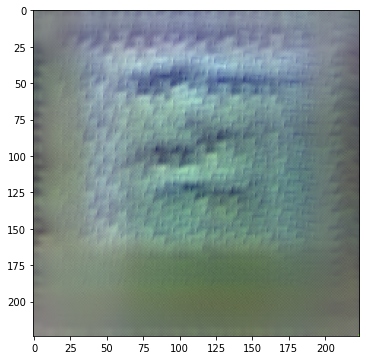

In [50]:
from vis.visualization import visualize_activation

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

img = visualize_activation(model, layer_idx, filter_indices=1)
plt.imshow(img)

Iteration: 1, named_losses: <zip object at 0x7fcd3596c308>, overall loss: 6373.71435546875
Iteration: 2, named_losses: <zip object at 0x7fcd3596c448>, overall loss: 3122.86376953125
Iteration: 3, named_losses: <zip object at 0x7fcd3596c508>, overall loss: 1617.1192626953125
Iteration: 4, named_losses: <zip object at 0x7fcd3596c348>, overall loss: 817.9190063476562
Iteration: 5, named_losses: <zip object at 0x7fcd3596c688>, overall loss: 392.1119689941406
Iteration: 6, named_losses: <zip object at 0x7fcd3596c788>, overall loss: 200.62771606445312
Iteration: 7, named_losses: <zip object at 0x7fcd3596c508>, overall loss: 143.870361328125
Iteration: 8, named_losses: <zip object at 0x7fcd3596c8c8>, overall loss: 95.79515075683594
Iteration: 9, named_losses: <zip object at 0x7fcd3596c788>, overall loss: 70.82982635498047
Iteration: 10, named_losses: <zip object at 0x7fcd3596ca48>, overall loss: 52.351417541503906
Iteration: 11, named_losses: <zip object at 0x7fcd3596cb48>, overall loss: 43.0

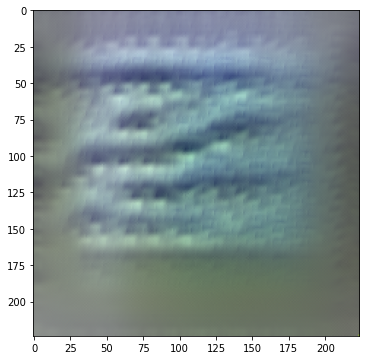

In [51]:
img = visualize_activation(model, layer_idx, filter_indices=10, max_iter=500, verbose=True)
plt.imshow(img)

We can see that the loss appears to be converging. So more iterations definitely seem to give better output. One way to get crisper results is to use `Jitter` input_modifier. As the name suggests, `Jitter` moves pixels around in the image. Lets try this out.

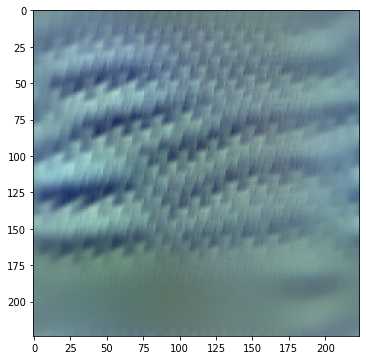

In [52]:
from vis.input_modifiers import Jitter

# Jitter 16 pixels along all dimensions to during the optimization process.
img = visualize_activation(model, layer_idx, filter_indices=20, max_iter=500, input_modifiers=[Jitter(16)])
plt.imshow(img)

## Visualizing Conv filters

In a CNN, each Conv layer has several learned *template matching* filters that maximize their output when a similar 
template pattern is found in the input image. 

One way of interpreting them is to generate an input image that maximizes the filter output. This allows us to generate an input that activates the filter.

In [53]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

## Visualizing all filters in an image 

This next cell takes a while to execute so we will focus on visualizing only subsets of filters within a layer.

In [0]:
# from vis.visualization import get_num_filters

# # The name of the layer we want to visualize
# # You can see this in the model definition.
# # layer_name = 'conv5_block16_2_conv' # 'block1_conv2'
# layer_idx = utils.find_layer_idx(model, layer_name)

# # Visualize all filters in this layer.
# filters = np.arange(get_num_filters(model.layers[layer_idx]))

# # Generate input image for each filter.
# vis_images = []
# for idx in filters:
#     img = visualize_activation(model, layer_idx, filter_indices=idx)
    
#     # Utility to overlay text on image.
#     img = utils.draw_text(img, 'Filter {}'.format(idx))    
#     vis_images.append(img)

# # Generate stitched image palette with 8 cols.
# stitched = utils.stitch_images(vis_images, cols=8)    
# plt.axis('off')
# plt.imshow(stitched)
# plt.title(layer_name)
# plt.show()

They mostly seem to match for specific color and directional patterns. Lets randomly visualize 10 filters within our chosen layer.

Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default


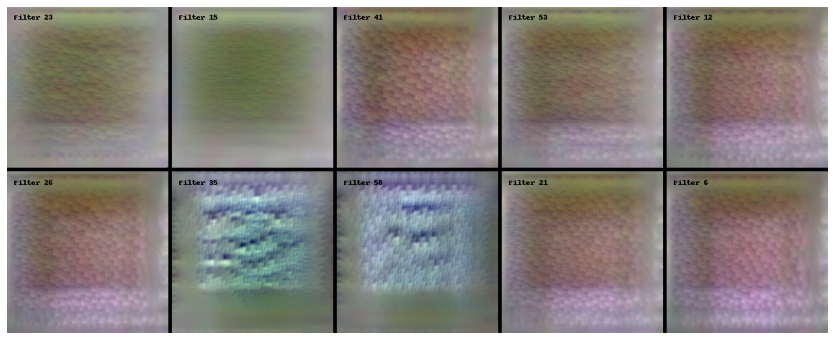

In [55]:
import numpy as np
from vis.visualization import get_num_filters

selected_indices = []

layer_idx = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer.
filters = np.random.permutation(get_num_filters(model.layers[layer_idx]))[:10]
selected_indices.append(filters)

# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)

    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

# Generate stitched image palette with 5 cols so we get 2 rows.
stitched = utils.stitch_images(vis_images, cols=5)    
plt.figure()
plt.axis('off')
plt.imshow(stitched)
plt.show()

We can see how filters evolved to look for simple -> complex abstract patterns.

Sometimes, filters fail to converge.  This is usually because regularization losses (total variation and LP norm) are overtaking activation maximization loss (set verbose=True to observe). There are a couple of options to make this work better,

- Different regularization weights.
- Increase number of iterations.
- Add `Jitter` input_modifier.
- Try with 0 regularization weights, generate a converged image and use that as `seed_input` with regularization enabled.

I will show a subset of these ideas here. Lets start by adding Jitter and disabling total variation.

Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default


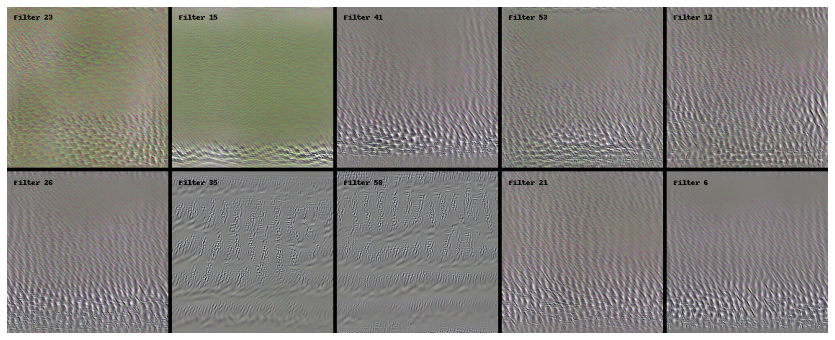

In [56]:
from vis.input_modifiers import Jitter

# layer_idx = utils.find_layer_idx(model, 'block5_conv3')
# layer_name = 'conv5_block16_2_conv'
layer_idx = utils.find_layer_idx(model, layer_name)
# We need to select the same random filters in order to compare the results.
filters = selected_indices[-1]
selected_indices.append(filters)

# Generate input image for each filter.
vis_images = []
for idx in filters:
    # We will jitter 5% relative to the image size.
    img = visualize_activation(model, layer_idx, filter_indices=idx, 
                               tv_weight=0.,
                               input_modifiers=[Jitter(0.05)])

    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

# Generate stitched image palette with 5 cols so we get 2 rows.
stitched = utils.stitch_images(vis_images, cols=5)    
plt.figure()
plt.axis('off')
plt.imshow(stitched)
plt.show()

We can see how previously unconverged filters show something this time. Lets take a specific output from here and use it as a `seed_input` with total_variation enabled this time.

Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default


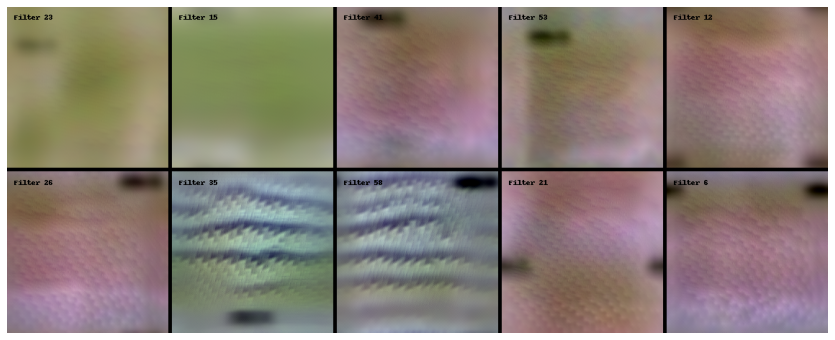

In [57]:
# Generate input image for each filter.
new_vis_images = []
for i, idx in enumerate(filters):
    # We will seed with optimized image this time.
    img = visualize_activation(model, layer_idx, filter_indices=idx, 
                               seed_input=vis_images[i],
                               input_modifiers=[Jitter(0.05)])

    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    new_vis_images.append(img)

# Generate stitched image palette with 5 cols so we get 2 rows.
stitched = utils.stitch_images(new_vis_images, cols=5)    
plt.figure()
plt.axis('off')
plt.imshow(stitched)
plt.show()